In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In order to make the dataset, the raw data must be in a directory 'Not_Zip' and named with its state name, e.g. 'Not_Zip/AZ.csv' for Arizona

### States to keep:

Republicans: 
1. Arizona (3.5 million)
2. Ohio (7.2 million) -> discarded
3. South Carolina (9 million)
4. Texas (27 million)

Democrats:
1. California (32 million)
2. Connecticut (1 million)
3. Illinois (13 million)
4. Rhode Island (510 000) -> discarded

### Features to take:
1. Date
2. Race
3. Sex

Take 300 000 datapoint per set -> we end with a dataset with roughly 2 million datapoints

In [2]:
PATH = 'Not_Zip/'
cols_to_use = ['date','subject_race', 'subject_sex', 'search_conducted']
States = ['AZ', 'SC', 'TX', 'CA', 'CT', 'IL']
number_subsamples = 300000

In [3]:
# Get the biggest time range for which all datasets contains values
min_date = dt.datetime(1900,1,1)
max_date = dt.datetime(2030,1,1)

for state in States:
    
    df = pd.read_csv(PATH + state + '.csv', usecols = cols_to_use)
    df.dropna(inplace = True)
    df.date = pd.to_datetime(df.date)
    df_min_date = df.date.min()
    df_max_date = df.date.max()
    
    if df_min_date > min_date:
        min_date = df_min_date
    
    if df_max_date < max_date:
        max_date = df_max_date

print('Min_date = {}, Max_date = {}'.format(min_date, max_date))    

Min_date = 2013-10-01 00:00:00, Max_date = 2015-10-01 00:00:00


In [4]:
df = pd.DataFrame([], columns = ['date', 'subject_race', 'subject_sex', 'search_conducted', 'State', 'Partisanship'])
republicans = ['TX', 'SC', 'AZ']
for state in States:
    
    # Get the dataset with only the desired columns
    df_state = pd.read_csv(PATH + state + '.csv', usecols = cols_to_use)
    
    # Drop nan values
    df_state.dropna(inplace = True)
    
    # Only keep Hispanic, Black and White drivers
    df_state = df_state.iloc[[x in ['hispanic', 'black', 'white'] for x in df_state.subject_race]]
    
    # Keep only data in the good time range
    df_state.date = pd.to_datetime(df_state.date)
    df_state = df_state[(df_state.date > min_date) & (df_state.date < max_date)]
    
    # Randomly create indices of the datapoints to keep
    inds = np.random.permutation(range(df_state.shape[0]))[:number_subsamples]
    
    # Keep only the subsample
    df_state = df_state.iloc[inds]
    
    # Append the state so that we know where the datapoints come from
    df_state['State'] = df_state.date.apply(lambda x: state)
    df_state['Partisanship'] = df_state.State.apply(lambda x: 'R' if x in republicans else 'D')
    
    # Concatenate with the final dataset
    df = pd.concat((df, df_state))
    
    del df_state
    
    print('State {} processed.'.format(state))

State AZ processed.
State SC processed.
State TX processed.
State CA processed.
State CT processed.
State IL processed.


In [5]:
df.to_csv('data.csv', index = False)

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,date,subject_race,subject_sex,search_conducted,State,Partisanship
0,2014-02-05,white,male,False,AZ,R
1,2014-01-31,hispanic,male,False,AZ,R
2,2014-02-02,white,female,False,AZ,R
3,2014-05-25,hispanic,male,False,AZ,R
4,2015-05-01,white,male,False,AZ,R


# Count number of stops per state and per race

In [2]:
PATH = 'Not_Zip/'
cols_to_use = ['date','subject_race', 'subject_sex', 'search_conducted']
States = ['AZ', 'SC', 'TX', 'CA', 'CT', 'IL']
number_subsamples = 300000

In [3]:
min_date = dt.datetime(2013,10,1)
max_date  =dt.datetime(2015,10,1)

In [4]:
df_count = pd.DataFrame([], columns = ['subject_race', 'State','date'])
cols_to_use = ['subject_race', 'date']
republicans = ['TX', 'SC', 'AZ']
for state in States:
    
    df_state = pd.read_csv(PATH + state + '.csv', usecols = cols_to_use)

    # Drop nan values
    df_state.dropna(inplace = True)

    # Only keep Hispanic, Black and White drivers
    df_state = df_state.iloc[[x in ['hispanic', 'black', 'white'] for x in df_state.subject_race]]

    # Keep only data in the good time range
    df_state.date = pd.to_datetime(df_state.date)
    df_state = df_state[(df_state.date > min_date) & (df_state.date < max_date)]

    # Append the state so that we know where the datapoints come from
    df_state['State'] = df_state.date.apply(lambda x: state)

    df_count = pd.concat((df_count,df_state.groupby(['State', 'subject_race']).count()['date'].reset_index()))
    
df_count.columns = ['subject_race', 'State', 'count']

In [5]:
df_count

,subject_race,State,count
0,black,AZ,57999
1,hispanic,AZ,261458
2,white,AZ,578846
0,black,SC,515716
1,hispanic,SC,63057
2,white,SC,892275
0,black,TX,356501
1,hispanic,TX,1326685
2,white,TX,1803647
0,black,CA,699019


In [6]:
df_count.to_csv('Number_Stops.csv')

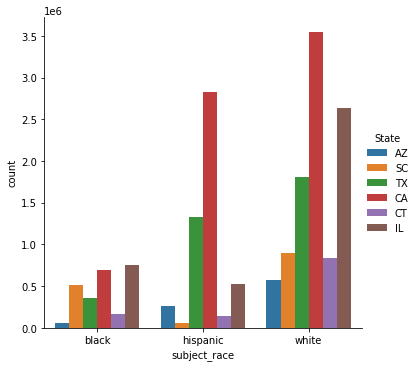

In [76]:
sns.catplot(data = df_count, x = 'subject_race', y = 'count', kind = 'bar', hue = 'State')

In [93]:
population = pd.DataFrame([('AZ', 6.7e6), ('SC', 4.8e6), ('TX',27e6), ('CA',38.5e6), ('CT',3.6e6), ('IL', 12.9e6)], columns = ['State', 'count'])

In [94]:
population

,State,count
0,AZ,6700000.0
1,SC,4800000.0
2,TX,27000000.0
3,CA,38500000.0
4,CT,3600000.0
5,IL,12900000.0
